In [1]:
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext
from bigdl.util.common import *


# create sparkcontext with bigdl configuration
sc = SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession(sparkContext = sc)
spark.conf.set("spark.sql.session.timeZone", "UTC")

df = spark.read.csv(f"hdfs://localhost:9000/solar_data/processed/Arkansas_1.csv", inferSchema=True, header=True)

Prepending /home/dyllanjr/anaconda3/envs/solarenv/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


In [2]:
spark

In [3]:
##The cloud type features are categorical.
#For my baseline, I'll just ignore them as they're already ordinally encoded
#I don't want to one hot encode 24*12 more columns
#I'll try to use a  Cat2Vec embedding for the LSTM model
#https://towardsdatascience.com/deep-embeddings-for-categorical-variables-cat2vec-b05c8ab63ac0
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- Cloud_Type_0: integer (nullable = true)
 |-- Cloud_Type_1: integer (nullable = true)
 |-- Cloud_Type_2: integer (nullable = true)
 |-- Cloud_Type_3: integer (nullable = true)
 |-- Cloud_Type_4: integer (nullable = true)
 |-- Cloud_Type_5: integer (nullable = true)
 |-- Cloud_Type_6: integer (nullable = true)
 |-- Cloud_Type_7: integer (nullable = true)
 |-- Cloud_Type_8: integer (nullable = true)
 |-- Cloud_Type_9: integer (nullable = true)
 |-- Cloud_Type_10: integer (nullable = true)
 |-- Cloud_Type_11: integer (nullable = true)
 |-- Cloud_Type_12: integer (nullable = true)
 |-- Cloud_Type_13: integer (nullable = true)
 |-- Cloud_Type_14: integer (nullable = true)
 |-- Cloud_Type_15: integer (nullable = true)
 |-- Cloud_Type_16: integer (nullable = true)
 |-- Cloud_Type_17: integer (nullable = true)
 |-- Cloud_Type_18: integer (nullable = true)
 |-- Cloud_Type_19: 

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

#Using all columns first
cols = df.columns
cols.remove('sum(GHI)')

#vectorize features
assembler = VectorAssembler(inputCols=cols, outputCol='features')
data = assembler.transform(df)

#train/test split
train, test = data.randomSplit([.8, .2])

##Configuring ML pipeline (might use format later)
lr = LinearRegression(featuresCol='features', labelCol='sum(GHI)')
pipeline = Pipeline(stages=[lr])


paramGrid = (ParamGridBuilder()
                 .addGrid(lr.elasticNetParam, [0, 0.1, 0.3, .5, .7, 0.01, .03, .05, .07])
                 .build())

crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=RegressionEvaluator(labelCol='sum(GHI)'),
                         numFolds=3)

cvModel1 = crossval.fit(train)



In [5]:
lrModel1 = cvModel1.bestModel.stages[0] 
trainingSummary = lrModel1.summary

print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Training r2: %f" % trainingSummary.r2)


Training RMSE: 1428.534508
Training r2: 0.893685


In [6]:
evaluator = RegressionEvaluator(labelCol='sum(GHI)')
test_preds = lrModel1.transform(test)
print("Test RMSE: ", evaluator.evaluate(test_preds))
evaluator = RegressionEvaluator(labelCol='sum(GHI)', metricName='r2')
print("Test r2: ", evaluator.evaluate(test_preds))

Test RMSE:  1393.362698024575
Test r2:  0.896980140877232


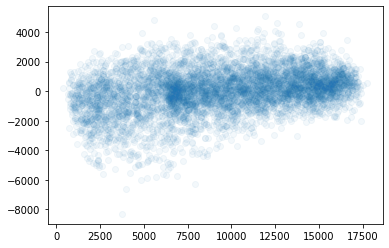

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

###check for homoscedasticity on the training set
#The model has relatively random residuals, but they "tighten up" closer to zero when predicting higher values
resids = trainingSummary.residuals.toPandas()
ytrue_train = train.select('sum(GHI)').toPandas()

plt.scatter(ytrue_train, resids, alpha=.05)

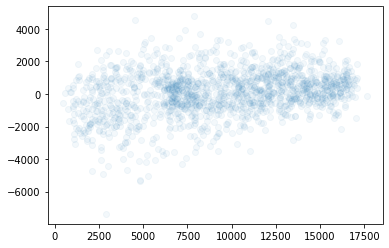

In [8]:
### Check for homoscedasticity on the test set
from pyspark.sql.functions import col
test_preds = test_preds.withColumn('resids', col('sum(GHI)') - col('prediction'))
resids = test_preds.select('resids').toPandas()
ytrue_test = test_preds.select('sum(GHI)').toPandas()
plt.scatter(ytrue_test, resids, alpha=.05)
#same patter of slight heteroscedasticity

In [9]:
#Dropping multicollinear (with dew point) Temp columns
cols = df.columns
for hour in range(0, 24):
    cols.remove("Temperature_"+str(hour))
cols.remove('sum(GHI)')

#vectorize features
assembler = VectorAssembler(inputCols=cols, outputCol='features')
data = assembler.transform(df)

#train/test split
train, test = data.randomSplit([.8, .2])

##Configuring ML pipeline (might use format later)
lr = LinearRegression(featuresCol='features', labelCol='sum(GHI)')
pipeline = Pipeline(stages=[lr])


paramGrid = (ParamGridBuilder()
                 .addGrid(lr.elasticNetParam, [0, 0.1, 0.3, .5, .7, 0.01, .03, .05, .07])
                 .build())

crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=RegressionEvaluator(labelCol='sum(GHI)'),
                         numFolds=3)

cvModel2 = crossval.fit(train)

In [10]:
lrModel2 = cvModel2.bestModel.stages[0] 
trainingSummary = lrModel2.summary

print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Training r2: %f" % trainingSummary.r2)

Training RMSE: 1582.199304
Training r2: 0.869655


In [11]:
evaluator = RegressionEvaluator(labelCol='sum(GHI)')
test_preds = lrModel2.transform(test)
print("Test RMSE: ", evaluator.evaluate(test_preds))
evaluator = RegressionEvaluator(labelCol='sum(GHI)', metricName='r2')
print("Test r2: ", evaluator.evaluate(test_preds))

Test RMSE:  1581.316307997216
Test r2:  0.8670887324159067


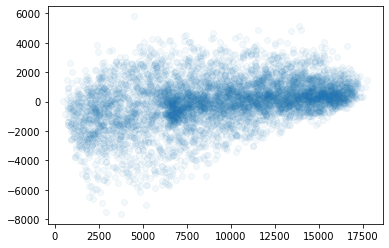

In [12]:
###check for homoscedasticity on the training set
#The model has relatively random residuals, but they "tighten up" closer to zero when predicting higher values
resids = trainingSummary.residuals.toPandas()
ytrue_train = train.select('sum(GHI)').toPandas()

plt.scatter(ytrue_train, resids, alpha=.05)

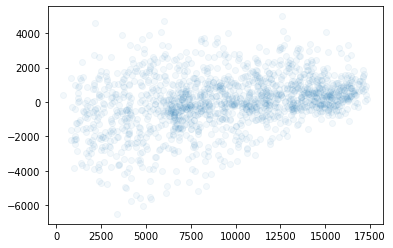

In [13]:
### Check for homoscedasticity on the test set
from pyspark.sql.functions import col
test_preds = test_preds.withColumn('resids', col('sum(GHI)') - col('prediction'))
resids = test_preds.select('resids').toPandas()
ytrue_test = test_preds.select('sum(GHI)').toPandas()
plt.scatter(ytrue_test, resids, alpha=.05)
#same pattern of slight heteroscedasticity

In [14]:
#Dropping multicollinear (with dew point) Temp columns
cols = df.columns
for hour in range(0, 24):
    cols.remove("Dew_Point_"+str(hour))
cols.remove('sum(GHI)')

#vectorize features
assembler = VectorAssembler(inputCols=cols, outputCol='features')
data = assembler.transform(df)

#train/test split
train, test = data.randomSplit([.8, .2])

##Configuring ML pipeline (might use format later)
lr = LinearRegression(featuresCol='features', labelCol='sum(GHI)')
pipeline = Pipeline(stages=[lr])


paramGrid = (ParamGridBuilder()
                 .addGrid(lr.elasticNetParam, [0, 0.1, 0.3, .5, .7, 0.01, .03, .05, .07])
                 .build())

crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=RegressionEvaluator(labelCol='sum(GHI)'),
                         numFolds=3)

cvModel3 = crossval.fit(train)

In [15]:
lrModel3 = cvModel3.bestModel.stages[0] 
trainingSummary = lrModel3.summary

print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Training r2: %f" % trainingSummary.r2)

Training RMSE: 1488.620611
Training r2: 0.884633


In [16]:
evaluator = RegressionEvaluator(labelCol='sum(GHI)')
test_preds = lrModel3.transform(test)
print("Test RMSE: ", evaluator.evaluate(test_preds))
evaluator = RegressionEvaluator(labelCol='sum(GHI)', metricName='r2')
print("Test r2: ", evaluator.evaluate(test_preds))

Test RMSE:  1505.7160127114164
Test r2:  0.8793479437622354


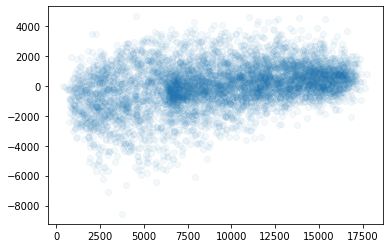

In [17]:
###check for homoscedasticity on the training set
#The model has relatively random residuals, but they "tighten up" closer to zero when predicting higher values
resids = trainingSummary.residuals.toPandas()
ytrue_train = train.select('sum(GHI)').toPandas()

plt.scatter(ytrue_train, resids, alpha=.05)

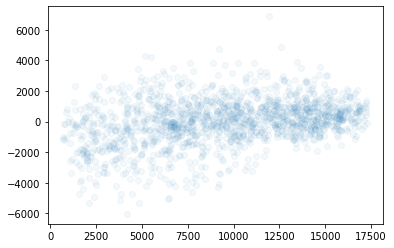

In [18]:
### Check for homoscedasticity on the test set
from pyspark.sql.functions import col
test_preds = test_preds.withColumn('resids', col('sum(GHI)') - col('prediction'))
resids = test_preds.select('resids').toPandas()
ytrue_test = test_preds.select('sum(GHI)').toPandas()
plt.scatter(ytrue_test, resids, alpha=.05)
#same pattern of slight heteroscedasticity

In [19]:
###The model performed best when I kept both multicollinear columns (temp / dew point)
#Since I care more about model predictive strength than I do about model interpretability,
#I'm going to go with the model that utilizes both temp/dew point columns.

In [20]:
#best elastic net regularization parameter was no regularization
lrModel1._java_obj.getRegParam()

0.0

In [21]:
lrModel1.save("/home/dyllanjr/Solar_Irradiance_Prediction/models/lrModel1_Baseline")

Py4JJavaError: An error occurred while calling o16273.save.
: java.io.IOException: Path /home/dyllanjr/Solar_Irradiance_Prediction/models/lrModel1_Baseline already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:702)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:179)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
